# Smart Data Analytics
Estimating volatility of the Crix index with a LSTM neural network

In [1]:
#Load Libraries
import json
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import urllib.request, json 

from keras.optimizers       import Adam
from keras.models           import Sequential
from keras.layers           import Dense
from keras.layers           import LSTM
from keras.models           import load_model

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

/Users/lukas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Hyperparameters
look_back = 10
epochs = 1

## Dataset

In [3]:
with urllib.request.urlopen("http://thecrix.de/data/crix.json") as url:
    data = json.loads(url.read().decode())
    
#Convert the data in a pandas dataframe
crix_data = pd.DataFrame(data = data[:-1]) 
crix_data = crix_data.set_index('date')
crix_data['returns'] = np.log(crix_data.price / crix_data.price.shift(1))
crix_data['vol'] = np.square(crix_data['returns'])
crix_data['ewma'] = crix_data['vol'].ewm(span = look_back).mean()

#Remove the first row containing 'Nan' Values
crix_data.drop(crix_data.index[0], inplace = True)

#Display the first 5 rows of the dataset
crix_data.tail(5)

,price,returns,vol,ewma
date,,,,
2018-10-27,15883.986354,0.001462,0.000002,0.000193
2018-10-28,15820.113745,-0.004029,0.000016,0.000161
2018-10-29,15910.018808,0.005667,0.000032,0.000137
2018-10-30,15336.031699,-0.036744,0.001350,0.000358
2018-10-31,15461.707510,0.008161,0.000067,0.000305


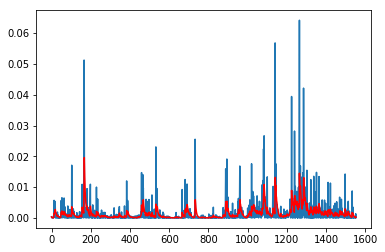

In [4]:
plt.plot(crix_data['vol'].values)
plt.plot(crix_data['ewma'].values, color = 'red')
plt.show()

In [5]:
return_series = crix_data['ewma'].values
return_series = return_series.reshape(len(return_series),1)
return_series = return_series.astype('float32')


#Normalize the values to a range from zero to 1
scaler            = MinMaxScaler(feature_range=(0, 1))
return_series     = scaler.fit_transform(return_series)

#Split the data into a training and test set
#We are using 80 percent of the data as training set and 20% as the test set. 
train_size  = int(len(return_series) * 0.80)
test_size   = len(return_series) - train_size

train, test = return_series[0:train_size], return_series[train_size:len(return_series)]

In [6]:
#Create Data Set
#dataX is the is the rolling window of past oberservations 
#dataY becomes the the value that is one day ahead of the rolling window. 
#This is the label/prediction for the past values

def create_dataset(time_series, look_back):
    dataX, dataY = [], []
    
    for i in range(1,len(time_series) - look_back - 1):
        
        x = time_series[i:i + look_back]
        dataX.append(x)
        
        y = time_series[i + look_back + 1]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY)

In [7]:
#Create the dataset with rolling window for the training set and test set
trainX, trainY  = create_dataset(train, look_back)
testX, testY    = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX  = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX   = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Model

In [8]:
#Create the model
#LSTM Neural Network with 128 Nodes is 3 Layers, followed by dense layer that outputs the prediction

model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape=(1, look_back)))
model.add(LSTM(128, return_sequences = True))
model.add(LSTM(128))
model.add(Dense(1))
optimizer = Adam(lr = 0.0001)
model.compile(loss = 'mean_squared_error', optimizer = optimizer)

#TODO: Try diffrent (smaller) model architectures, add regularization

In [9]:
#Train the model, epochs is the number of iterations

model.fit(trainX, trainY, epochs = epochs, batch_size = 1, verbose = 1)

Epoch 1/1
1230/1230 [==============================] - 22s 18ms/step - loss: 0.0064


In [10]:
model.save('Output/Model_LB-'+ str(look_back) + '_EP-'+str(epochs)+'.h5')

In [11]:
#Make predictions 
trainPredict    = model.predict(trainX)
testPredict     = model.predict(testX)

#Inverse the normalization procedure of the data
trainY = np.reshape(trainY,(trainY.shape[0],))
testY  = np.reshape(testY,(testY.shape[0],))

trainPredict    = scaler.inverse_transform(trainPredict)
trainY          = scaler.inverse_transform([trainY])
testPredict     = scaler.inverse_transform(testPredict)
testY           = scaler.inverse_transform([testY])

## Evaluate

In [12]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.6f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.6f RMSE' % (testScore))

Train Score: 0.001333 RMSE
Test Score: 0.001513 RMSE


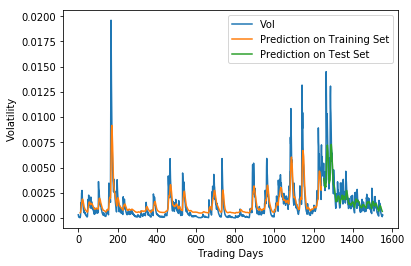

In [13]:
#plt.plot(crix_data['vol'].values, color = 'grey')

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(return_series)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(return_series)
testPredictPlot[:, :]= np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 2:len(return_series)-2, :] = testPredict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(return_series), label = 'Vol')
plt.plot(trainPredictPlot, label = 'Prediction on Training Set')
plt.plot(testPredictPlot, label = 'Prediction on Test Set')

plt.legend()
plt.xlabel('Trading Days')
plt.ylabel('Volatility')
plt.savefig('Output/Plot_LB-'+ str(look_back) + '_EP-'+str(epochs)+'.png', dpi=500)
plt.show()